In [ ]:
!pip install accessify
%matplotlib inline
import sympy
import matplotlib.pyplot as plt
import numpy as np
from random import random, randint, randrange
import math
import scipy
from accessify import private
import shapely
from shapely.geometry import Polygon as SPolygon
from shapely.ops import triangulate

In [ ]:
def draw_polygon(polygon, names=None, color='g'):
    ax = plt.gca()
    ax.set_aspect('equal')
    vertices = polygon.vertices
    points_x = [item.x for item in vertices] + [vertices[0].x]
    points_y = [item.y for item in vertices] + [vertices[0].y]
    ax.plot(points_x, points_y, color)

> Здесь реализован алгоритм поиска пересечения двух многоугольников. Для многоугольников, которые принимает алгоритм, наложены следующие ограничения: вершины должны задаваться в порядке обхода против часовой стрелки (алгоритм должен работать даже если точки заданы по часовой стрелке, но писалось все для случая против часовой, поэтому корректность в случае неправильного порядка указания точек не гарантирована); многоугольники могут быть невыпуклыми, но обязательно должны быть без внутренних отверстий/самопересечений/самокасаний. Примечание: данный алгоритм считает, что границы многоугольника не принадлежат многоугольнику. Поэтому, если фигуры просто касаются, то их пересечение - пустое.

> Алгоритм работает следующим образом: триангулирует оба многоугольника, находит попарное пересечение треугольников из триангуляции, эти пересечения (при необходимости) триангулирует, потом склеивает множество треугольников (пересечений триангуляций обоих многоугольников) в множество непересекающихся мноугольников, образующих пересечение двух исходных многоугольников.

> Далее считаем, что нужно найти пересечение n и m угольника.

> Более подробно про каждую фазу: для триангуляции многоугольников используется триангуляция из библиотеки shapely. Там используется алгоритм триангуляции за O(n * log(n)). То есть триангуляция исходных многоугольников займет O(n * log(n) + m * log(m)). Далее идет фаза поиска попарных пересечений треугольников из триангуляции. Пересечением двух треугольников может быть: ничего (треугольники не пересекаются), точка, отрезок, треугольник, выпуклый четрехугольник, выпуклый пятиугольник или выпуклый шестиугольник. То есть это всегда выпуклая фигура. Я нахожу точки, образующие пересечение этих треугольников (это точка одного треугольника, лежащая в другом треугольнике/на его границе; пересечения сторон треугольников). От этих точек строю выпуклую оболочку. То есть нужно просто найти точки пересечения отрезков/вложения многоугольников, построить от них выпуклую оболочку, фактически это перебор случаев и алгоритм Грэхема на 6 точек, можно считать, что временные затраты на пересечение двух треугольников O(1). Всего нужно проверить O(n * m) пар треугольников на предмет пересечений, то есть затраты на выполнение этой части алгоритма O(n * m). Далее нужно склеить треугольники, образующие пересечение исходных многоугольников, в многоугольники. Для этого я строю граф на вершинах, которые есть хотя бы в одном из треугольников, который входит в пересечение. В граф добавляется ребро только если существует ровно 1 треугольник, который имеет сторону, основанную двумя вершинами, между которыми я пытаюсь добавить ребро (это сделано для того, чтобы получить границы многоугольников, входящих в пересечение). На этом графе я запускаю dfs, он проходится по каждой точке и добавляет в порядке обхода эти точки в список. Прохожусь dfsом по кажой компоненте связности, получаю список многоугольников. Потом конвертирую каждое множество точек из списка в sympy polygon (за одно убираются точки, которые лежат на отрезках многоугольников, не образующие углы) и возвращаю. То есть в итоге ассимптотика O(n * m), самая узкая часть это поиск попарных пересечений треугольников.

> Решение обернуто в класс Intersector, все что не нужно внешнему миру сделано приватными методами. Доступны методы GetFiguresIntersection (принимает в себя 2 многоугольника с указанными ограничениями и возвращает список многоугольников, являющихся их пересечениями) и Triangulation (принимает в себя многоугольник с указанными ограничениями, возвращает список треугольников, образующих триангуляцию исходного многоугольниква).

> Я немного занялся сравнением производительности моего алгоритма пересечений и встроенного алгоритма sympy, мой алгоритм в целом работает быстрее, в некоторых случаях время работы почти в 4 раза меньше.

In [ ]:
class Intersector:

  @private
  def StrongCheckIfPointInFigure(self, figure, point):
    if len(sympy.Line2D(figure.vertices[0], figure.vertices[1]).intersection(point)) > 0:
      if len(sympy.Segment2D(figure.vertices[0], figure.vertices[1]).intersection(point)) > 0:
        return True
      else:
        return False
    if len(sympy.Line2D(figure.vertices[0], figure.vertices[2]).intersection(point)) > 0:
      if len(sympy.Segment2D(figure.vertices[0], figure.vertices[2]).intersection(point)) > 0:
        return True
      else:
        return False
    if len(sympy.Line2D(figure.vertices[1], figure.vertices[2]).intersection(point)) > 0:
      if len(sympy.Segment2D(figure.vertices[1], figure.vertices[2]).intersection(point)) > 0:
        return True
      else:
        return False
    s_possible = abs(sympy.Polygon(figure.vertices[0], figure.vertices[1], point).area)
    s_possible += abs(sympy.Polygon(figure.vertices[0], figure.vertices[2], point).area)
    s_possible += abs(sympy.Polygon(figure.vertices[1], figure.vertices[2], point).area)
    return s_possible == abs(figure.area)
  

  @private
  def GetInternalPoints(self, figure1, figure2):
    dots = []
    for i in figure1.vertices:
      if self.StrongCheckIfPointInFigure(figure2, i):
        dots.append(i)
    for i in figure2.vertices:
      if self.StrongCheckIfPointInFigure(figure1, i):
        dots.append(i)
    return dots
  

  @private
  def GetBordersIntersections(self, figure1, figure2):
    segments1 = self.SegmentizeFigure(figure1)
    segments2 = self.SegmentizeFigure(figure2)
    dots = []
    for s1 in segments1:
      for s2 in segments2:
        i = s1.intersection(s2)
        if len(i) > 0 and type(i[0]) == sympy.Point2D:
          dots.append(i[0])
    return dots


  @private
  def GetTotalIntersections(self, figure1, figure2):
    dots = []
    for i in self.GetInternalPoints(figure1, figure2):
      dots.append(i)
    for i in self.GetBordersIntersections(figure1, figure2):
      dots.append(i)
    return dots
  

  @private
  def SegmentizeFigure(self, figure):
    segments = []
    points = figure.vertices
    for i in range(1, len(points)):
      segments.append(sympy.Segment(points[i], points[i - 1]))
    if len(points) > 2:
      segments.append(sympy.Segment(points[0], points[-1]))
    return segments
  

  @private
  def GetAngle(self, p1, p2, p3):
    x1 = p2.x - p1.x
    y1 = p2.y - p1.y
    x2 = p3.x - p2.x
    y2 = p3.y - p2.y
    return x1 * y2 - x2 * y1
  

  def Triangulation(self, figure):
    polygon = SPolygon([(i.x, i.y) for i in figure.vertices])
    triangles = []
    for i in [triangle for triangle in triangulate(polygon) if triangle.within(polygon)]:
      points = [sympy.Point(i.exterior.coords.xy[0][j], i.exterior.coords.xy[1][j]) for j in range(len(i.exterior.coords.xy[1]) - 1)]
      if self.GetAngle(points[0], points[1], points[2]) > 0:
        points = points[::-1]
      triangles.append(sympy.Polygon(*points))
    return triangles
  

  @private
  def GetLowestPoint(self, points):
    best_index = 0
    for i in range(1, len(points)):
      if points[i].y < points[best_index].y:
        best_index = i
      elif points[i].y == points[best_index].y and points[i].x < points[best_index].x:
        best_index = i
    return best_index
  

  @private
  def DFS(self, vertex):
    self.visited[vertex] = 1
    self.group[-1].append(vertex)
    for new_vertex in self.g[vertex]:
      if self.visited[new_vertex] == 0:
        self.DFS(new_vertex)
  

  @private
  def GetLessPoint(self, a, b):
    if a.y == b.y:
      if a.x < b.x:
        return a
      else:
        return b
    elif a.y < b.y:
      return a
    else:
      return b


  @private
  def SetGraph(self, figures):
    edges = {}
    for t in figures:
      dots = t.vertices
      for i in range(0, len(dots)):
        s = None
        if self.GetLessPoint(dots[i], dots[i - 1]) == dots[i - 1]:
          s = sympy.Segment2D(dots[i - 1], dots[i])
        else:
          s = sympy.Segment2D(dots[i], dots[i - 1])
        if not s in edges:
          edges.update({s : 1})
        else:
          edges[s] += 1
    g = {}
    for t in figures:
      dots = t.vertices
      for i in range(0, len(dots)):
        s = None
        if self.GetLessPoint(dots[i], dots[i - 1]) == dots[i - 1]:
          s = sympy.Segment2D(dots[i - 1], dots[i])
        else:
          s = sympy.Segment2D(dots[i], dots[i - 1])
        if edges[s] > 1:
          continue
        if not dots[i] in g:
          g[dots[i]] = [dots[i - 1]]
        else:
          g[dots[i]].append(dots[i - 1])
        if not dots[i - 1] in g:
          g[dots[i - 1]] = [dots[i]]
        else:
          g[dots[i - 1]].append(dots[i])
    for vertex in g:
      g[vertex] = list(set(g[vertex]))
    self.g = g


  @private
  def MergeTriangles(self, figures):
    self.SetGraph(figures)
    self.visited = {}
    for key in self.g:
      self.visited[key] = 0
    self.group = []
    for vertex in self.g:
      if self.visited[vertex] == 0:
        self.group.append([])
        self.DFS(vertex)
    return [sympy.Polygon(*i) for i in self.group]


  @private
  def GetSmallFiguresIntersection(self, figure1, figure2):
    dots = self.GetTotalIntersections(figure1, figure2)
    dots = list(set(dots))
    if len(dots) == 0:
      return []
    fig = sympy.Polygon(*dots)
    if type(fig) == sympy.Triangle or type(fig) == sympy.Polygon:
      return self.Triangulation(sympy.geometry.util.convex_hull(fig))
    else:
      return []
  

  def GetFiguresIntersection(self, figure1, figure2):
    small1 = self.Triangulation(figure1)
    small2 = self.Triangulation(figure2)
    inters = []
    for i in small1:
      for j in small2:
        now = self.GetSmallFiguresIntersection(i, j)
        for q in now:
          inters.append(q)
    return [i for i in self.MergeTriangles(inters) if type(i) == sympy.Triangle or type(i) == sympy.Polygon]
  

> Далее идут тесты

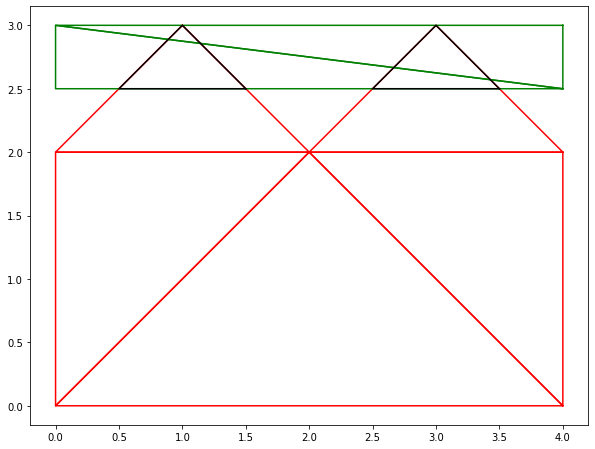

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 2), sympy.Point(1, 3), sympy.Point(2, 2), sympy.Point(3, 3), sympy.Point(4, 2), sympy.Point(4, 0))
f2 = sympy.Polygon(sympy.Point(0, 2.5), sympy.Point(0, 3), sympy.Point(4, 3), sympy.Point(4, 2.5))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon or True:
    draw_polygon(i, color='black')

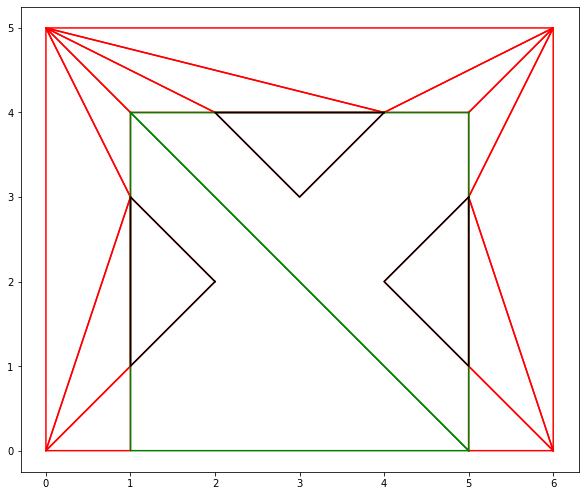

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 5), sympy.Point(6, 5), sympy.Point(6, 0), sympy.Point(5, 0), sympy.Point(5, 1), sympy.Point(4, 2), sympy.Point(5, 3), sympy.Point(5, 4),
                   sympy.Point(4, 4), sympy.Point(3, 3), sympy.Point(2, 4), sympy.Point(1, 4), sympy.Point(1, 3), sympy.Point(2, 2), sympy.Point(1, 1), sympy.Point(1, 0))
f2 = sympy.Polygon(sympy.Point(1, 0), sympy.Point(1, 4), sympy.Point(5, 4), sympy.Point(5, 0))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

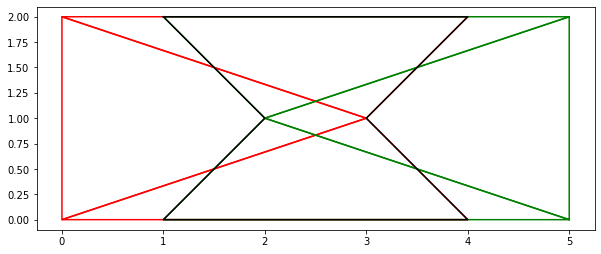

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 2), sympy.Point(4, 2), sympy.Point(3, 1), sympy.Point(4, 0))
f2 = sympy.Polygon(sympy.Point(1, 0), sympy.Point(2, 1), sympy.Point(1, 2), sympy.Point(5, 2), sympy.Point(5, 0))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

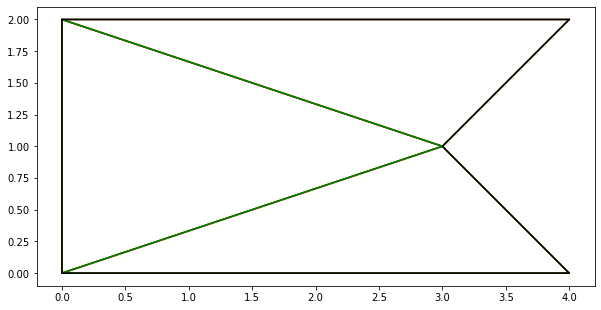

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 2), sympy.Point(4, 2), sympy.Point(3, 1), sympy.Point(4, 0))
f2 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 2), sympy.Point(4, 2), sympy.Point(3, 1), sympy.Point(4, 0))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

[]


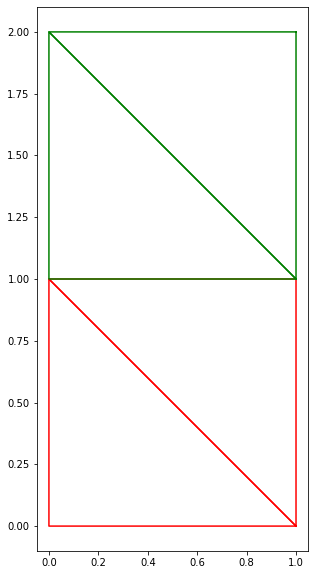

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 1), sympy.Point(1, 1), sympy.Point(1, 0))
f2 = sympy.Polygon(sympy.Point(0, 1), sympy.Point(0, 2), sympy.Point(1, 2), sympy.Point(1, 1))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
print(inters)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

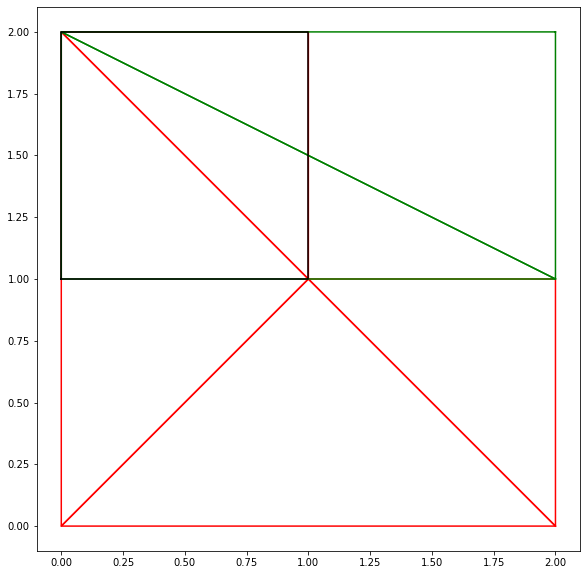

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 2), sympy.Point(1, 2), sympy.Point(1, 1), sympy.Point(2, 1), sympy.Point(2, 0))
f2 = sympy.Polygon(sympy.Point(0, 1), sympy.Point(0, 2), sympy.Point(2, 2), sympy.Point(2, 1))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

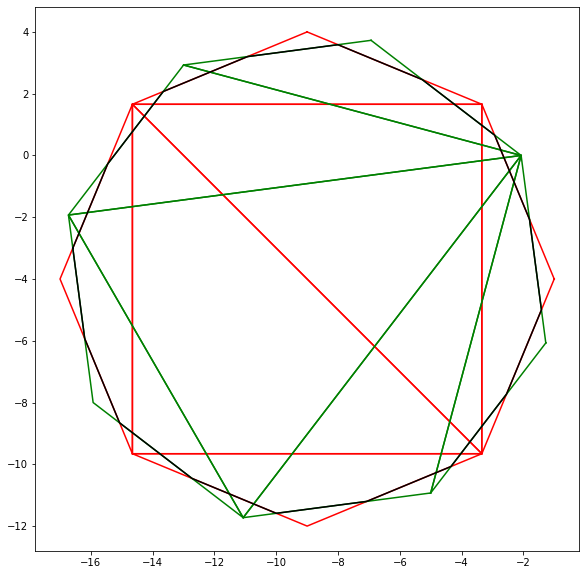

In [ ]:
def to_rad(alpha):
  return alpha / 180 * sympy.pi


O = sympy.Point(-9, -4)
R = 8
alpha = to_rad(135)
beta = to_rad(165)
f1 = sympy.Polygon(*[O + sympy.Point(R * sympy.cos(2 * sympy.pi * i / 8), R * sympy.sin(2 * sympy.pi * i / 8)) for i in range(8)])
f2 = f1.rotate(beta, pt=f1.centroid)
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')
#время выполнения: 40.2 секунды

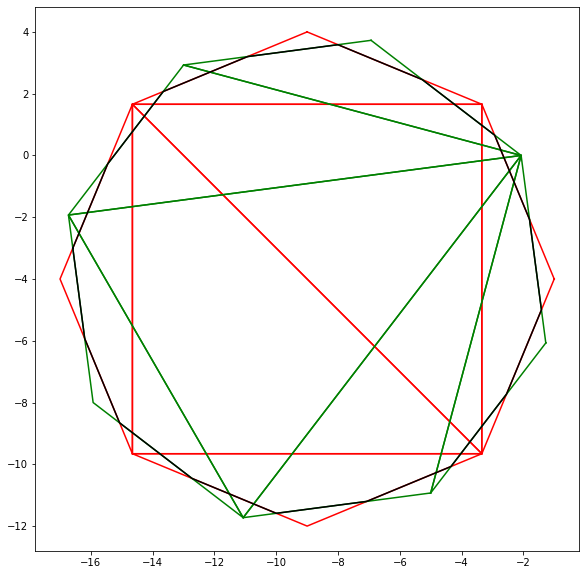

In [ ]:
def to_rad(alpha):
  return alpha / 180 * sympy.pi


O = sympy.Point(-9, -4)
R = 8
alpha = to_rad(135)
beta = to_rad(165)
f1 = sympy.Polygon(*[O + sympy.Point(R * sympy.cos(2 * sympy.pi * i / 8), R * sympy.sin(2 * sympy.pi * i / 8)) for i in range(8)])
f2 = f1.rotate(beta, pt=f1.centroid)
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = [sympy.geometry.util.convex_hull(sympy.Polygon(*f1.intersection(f2)))]
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')
#время выполнения: 177.5 секунд; и кроме того что дольше, встроенный поиск пересечений выдает точки в неправильном порядке, 
#приходится (как здесь, для выпуклых многоугольников) строить выпуклую оболочку, а для невыпуклых все очень плохо

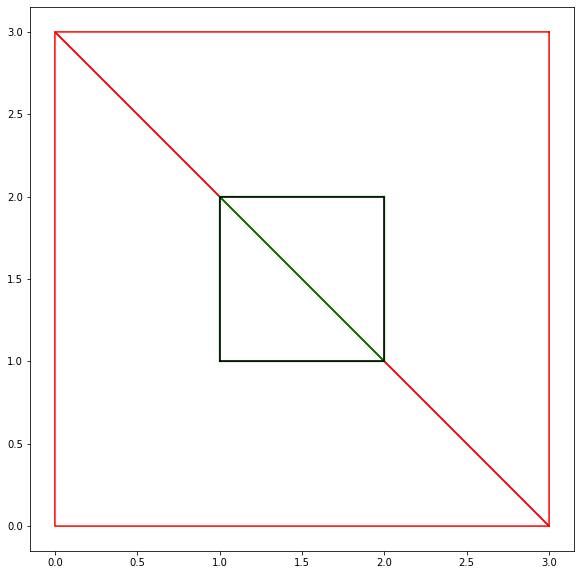

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 3), sympy.Point(3, 3), sympy.Point(3, 0))
f2 = sympy.Polygon(sympy.Point(1, 1), sympy.Point(1, 2), sympy.Point(2, 2), sympy.Point(2, 1))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')

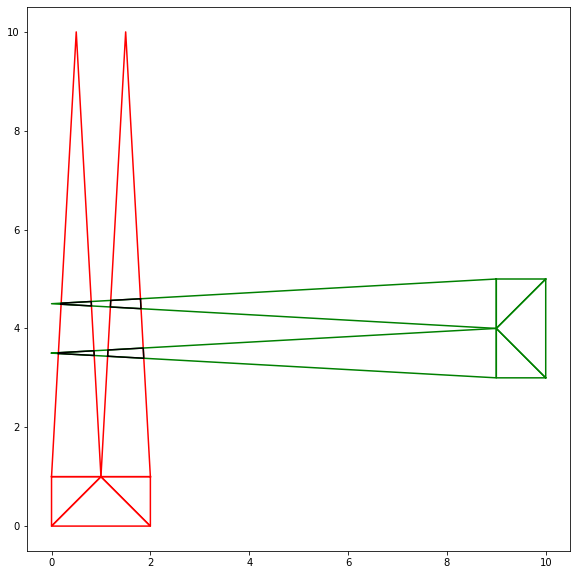

In [ ]:
f1 = sympy.Polygon(sympy.Point(0, 0), sympy.Point(0, 1), sympy.Point(0.5, 10), sympy.Point(1, 1), sympy.Point(1.5, 10), sympy.Point(2, 1), sympy.Point(2, 0))
f2 = sympy.Polygon(sympy.Point(0, 3.5), sympy.Point(9, 4), sympy.Point(0, 4.5), sympy.Point(9, 5), sympy.Point(10, 5), sympy.Point(10, 3), sympy.Point(9, 3))
plt.figure(figsize=(10, 10))
for i in Intersector().Triangulation(f1):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='red')
for i in Intersector().Triangulation(f2):
  if type(i) == sympy.Triangle:
    draw_polygon(i, color='green')
inters = Intersector().GetFiguresIntersection(f1, f2)
for i in inters:
  if type(i) == sympy.Triangle or type(i) == sympy.Polygon:
    draw_polygon(i, color='black')